In [1]:
import os
import re
import sys

import pandas as pd
import numpy as np

import requests
import json
import time
from PIL import Image
from matplotlib import pyplot
from tqdm.auto import tqdm

In [2]:
SAVE_DIR = './data/'

DATASET = 'environmental'

In [3]:
os.makedirs(os.path.join(SAVE_DIR, 'models/rank-embedding/list-models'), exist_ok=True)
os.makedirs(os.path.join(SAVE_DIR, 'get-image-rank-sigma-scores-by-model-id'), exist_ok=True)

# get models

In [4]:
url = 'http://123.176.98.90:8764/models/rank-embedding/list-models'

In [5]:
data = requests.get(f'{url}?dataset={DATASET}')

In [6]:
model_list = eval(data.content)

In [7]:
model_list = pd.DataFrame(model_list)
model_list.set_index('model_file_hash', inplace=True)

model_list.to_csv(os.path.join(SAVE_DIR, 'models/rank-embedding/list-models', f'{DATASET}.csv'))

In [8]:
model_list['model_type'].unique(), model_list['input_type'].unique()

(array(['xgboost-rank-pairwise', 'image-pair-ranking-linear',
        'image-pair-ranking-elm-v1'], dtype=object),
 array(['embedding-positive', 'embedding-negative', 'embedding', 'clip'],
       dtype=object))

In [9]:
# model_file_hashs = model_list.query('model_type == "image-pair-ranking-elm-v1" and input_type == "clip"').index
model_file_hashs = model_list.query('model_type == "image-pair-ranking-linear" and input_type == "clip"').index

# get model ids

In [10]:
url = 'http://123.176.98.90:8764/models/get-id'

In [11]:
model_ids = dict()

for model_hash in tqdm(model_file_hashs, leave=False):
    
    data = requests.get(f'{url}?model_hash={model_hash}')
    
    result = eval(data.content)
    
    if type(result) != int:
        continue
    
    model_ids[result] = model_hash

  0%|          | 0/29 [00:00<?, ?it/s]

# get sigma-scores

In [12]:
url = 'http://123.176.98.90:8764/sigma-score/get-image-rank-sigma-scores-by-model-id'

In [13]:
for model_id in tqdm(model_ids.keys(), leave=False):
    
    output_path = os.path.join(SAVE_DIR, 'get-image-rank-sigma-scores-by-model-id', f'{model_id}.json')
    
    if os.path.exists(output_path):
        continue
    
    data = requests.get(f'{url}?model_id={model_id}')
    
    result = eval(data.content)
    
    json.dump(result, open(output_path, 'wt'))

  0%|          | 0/26 [00:00<?, ?it/s]

# get dataset

In [14]:
results = list()

for model_id in tqdm(model_ids, leave=False):
    
    output_path = os.path.join(SAVE_DIR, 'get-image-rank-sigma-scores-by-model-id', f'{model_id}.json')
    
    result = json.load(open(output_path))
    
    if len(result) == 0:
        continue
    
    result = pd.DataFrame(result)
    result.drop_duplicates('image_hash', keep='first', inplace=True)
    result.set_index('image_hash', inplace=True)
    
    result = result[['sigma_score']]
    result.columns = [model_id]
    
    results.append(result)

  0%|          | 0/26 [00:00<?, ?it/s]

In [15]:
results = pd.concat(results, axis=1, join='inner')
selected_ids = results.columns

In [16]:
values = results[selected_ids].values.copy()

In [17]:
values = (values - values.mean(axis=0, keepdims=True)) / values.std(axis=0, keepdims=True)

In [32]:
results['sigma_score_mean'] = values.mean(axis=-1)
results['sigma_score_std'] = values.std(axis=-1)

In [19]:
selected_hashs = list(map(model_ids.get, selected_ids))

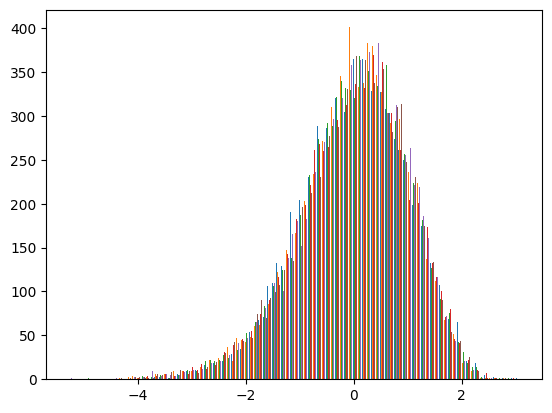

In [21]:
_ = pyplot.hist(values, bins=100)

# pyplot.plot(results['mean'], results['std'], '.', alpha=0.1)
# pyplot.title('image score and uncertainty')
# pyplot.xlabel('mean of sigma-scores')
# pyplot.ylabel('std of sigma-scores')

In [22]:
def get_bins(min_value: float, max_value: float, n_bins: int, add_inf=False):
    
    bins = np.linspace(min_value, max_value, n_bins)
    
    if add_inf:
        bins = np.array([-np.inf] + list(bins) + [np.inf])
    
    return bins

def sigma_score_to_category(sigma_scores: np.ndarray, bins: np.ndarray):
    
    return np.digitize(sigma_scores, bins)

def get_entropy(categories: np.ndarray):
    
    n_bins = int(categories.max()) + 1
    
    one_hot = np.eye(n_bins)[categories].sum(axis=-2)
    
    probabilities = one_hot / one_hot.sum(axis=-1, keepdims=True)
    
    entropy = - (probabilities * np.log2(probabilities + 1e-7)).sum(axis=-1)
    
    return entropy

In [23]:
bins = get_bins(-2, 1.5, 15, True)
category = sigma_score_to_category(values, bins)
entropy = get_entropy(category)

Text(0.5, 1.0, 'relation between entropy and sigma_score_std')

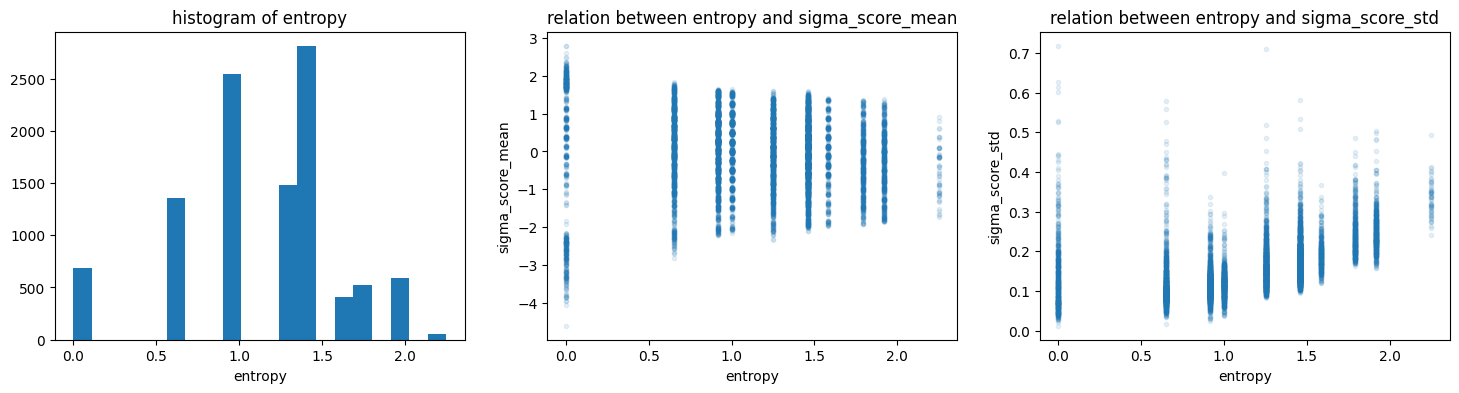

In [24]:
pyplot.figure(figsize=(18, 4))

pyplot.subplot(1, 3, 1)

pyplot.hist(entropy, bins=20)
pyplot.xlabel('entropy')
pyplot.title('histogram of entropy')

pyplot.subplot(1, 3, 2)

pyplot.plot(entropy, results['sigma_score_mean'], '.', alpha=0.1)
pyplot.xlabel('entropy')
pyplot.ylabel('sigma_score_mean')
pyplot.title('relation between entropy and sigma_score_mean')

pyplot.subplot(1, 3, 3)

pyplot.plot(entropy, results['sigma_score_std'], '.', alpha=0.1)
pyplot.xlabel('entropy')
pyplot.ylabel('sigma_score_std')
pyplot.title('relation between entropy and sigma_score_std')

# save ensemble results

In [29]:
PMT_PATH = './data/environmental/prompt.json'

In [30]:
prompts = json.load(open(PMT_PATH))

In [31]:
hash_to_path = {i:j['file_path'].split('_')[0] for i, j in prompts.items()}
hash_to_uuid = {i: j['job_uuid'] for i, j in prompts.items()}

In [37]:
results['entropy'] = entropy
results['job_uuid'] = list(map(hash_to_uuid.get, results.index))
results['file_path'] = list(map(hash_to_path.get, results.index))

In [39]:
results.dropna(inplace=True)

In [46]:
results[['job_uuid', 'file_path', 'sigma_score_mean', 'sigma_score_std', 'entropy']].query('sigma_score_mean > 1. and sigma_score_std > 0.2 and entropy > 1e-3').to_csv('2023-11-24-han-6-clip-ensemble-high-entropy.csv')

In [29]:
from minio import Minio
import requests
import msgpack

In [30]:
def connect_to_minio(minio_addr, access_key, secret_key):
    # Initialize the MinIO client
    client = Minio(minio_addr, access_key, secret_key, secure=False)

    #Check server status
    try:
        response = requests.get("http://" + minio_addr + "/minio/health/live", timeout=5)
        if response.status_code == 200:
            print("Connected to MinIO server.")
        else:
            return None
    except requests.RequestException as e:
        return None
    
    return client

In [31]:
MINIO_ADDRESS = "123.176.98.90:9000"
access_key = "GXvqLWtthELCaROPITOG"
secret_key = "DmlKgey5u0DnMHP30Vg7rkLT0NNbNIGaM8IwPckD"

In [32]:
client = connect_to_minio(MINIO_ADDRESS, access_key, secret_key)

Connected to MinIO server.


In [33]:
sys.path.append(os.path.abspath('../kcg-ml-image-pipeline/'))
from training_worker.ab_ranking.model.ab_ranking_elm_v1 import ABRankingELMBaseModel

In [35]:
ABRankingELMBaseModel(inputs_shape=768)

ABRankingELMBaseModel(
  (l1_loss): L1Loss()
  (linear_last_layer): Linear(in_features=768, out_features=1, bias=True)
)

In [67]:
model_weight = model_list.loc[selected_hashs, 'model_path'].values[0]
model_weight

'environmental/models/ranking/2023-11-22-00-score-elm-v1-clip.pth'

In [68]:
bucket_name = 'datasets'
client.fget_object(bucket_name, model_weight, os.path.join('data', model_weight))

In [71]:
model_dict = torch.load(os.path.join('data', model_weight))['model_dict']

In [72]:
{k: v.shape for k, v in model_dict.items()}

{'linear_last_layer.weight': torch.Size([1, 768]),
 'linear_last_layer.bias': torch.Size([1])}